In [1]:
import numpy as np
import pandas as pd
import json
import csv
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

%matplotlib inline

In [2]:
cd

C:\Users\yashd


In [3]:
df = pd.read_csv("Desktop/rethink-media/quote-classification/Data/cleaned_data/GNI88_cleaned_data.csv") # 408204 rows

C:\Users\yashd\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (9,10,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Preprocessing

In [4]:
# Dropping rows with no source names or text
df = df.dropna(subset=["Source Name", "fulltext"]) # 400044 rows
df = df[df['source_name_cleaned'].apply(lambda x: isinstance(x, str))]

# Filtering out opinion articles 
df = df[df["Article Status"] != "Opinion"] # 354192 rows

# Dropping unnamed sources
df = df[~df["Source Name"].str.lower().str.contains("unnamed")] # 311740

# Dropping household names
df = df[~df.source_name_cleaned.str.lower().str.contains("biden|trump|obama|bush|clinton|reagan|putin|kim jong un|netanyahu|ayatollah|moon jae in")] # 269676 rows
df.head()

,artdate,Article ID,Headline,Quote ID,Article Status,Article Position,Messages,Submessages,Quote Position,Legacy Quote Tag,...,Constituent Group,Media Name,Media Medium,Journalist Name,Constituent Author,Article Issues,Custom Group,Media Group,fulltext,source_name_cleaned
1,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105520,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,None (Legacy Other),News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,James Mattis
2,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105517,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,None (Legacy Other),News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,James Mattis
3,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105518,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Positive,NaN,...,NaN,News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,Leon E. Panetta
4,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105527,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,NaN,News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,Chuck Hagel
5,2018-02-15,3777414,"For His Book 'Directorate S,' Journalist Steve...",7105525,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Positive,NaN,...,None (Legacy Other),NPR,NaN,"Kelly, Mary",NaN,NaN,NaN,NaN,"For His Book 'Directorate S,' Journalist Steve...",Steve Coll


In [53]:
df.iloc[0]['fulltext']

'Can James Mattis Prevent Nuclear War With North Korea?\r\n\r\nJames Mattis has spent the past few months traveling the globe with Grant, Ron Chernow\'s biography of Ulysses S. Grant. His heavily dog-eared copy details the mutual respect and affection shared between Grant, the top U.S. military leader during the Civil War, and his boss, President Abraham Lincoln.\r\n\r\nWhile Grant publicly supported Lincoln, Mattis, the secretary of defense, has been noticeably quiet about his president, Donald Trump. At a bizarre Cabinet meeting in June 2017, in which nearly every other official offered effusive praise for Trump, Mattis didn\'t.\r\n\r\nInstead, he\'s been traveling the world while trying to hold back a rush to war on the Korean Peninsula, born of a rhetorical spat between his boss and North Korean dictator Kim Jong Un. His plane is a Cold War-era Boeing E4-B designed to help run a nuclear war from the air, a prospect he\'s hoping to avoid.\r\n\r\nMattis is facing a surge of support f

In [5]:
# dictionary containing the classification groups for all speaker types
source_groups = {"Foreign Government": ['Foreign Gov/Mil Official', 'Former Soviet Military Officer'],
                "Experts": ['Nuke Organization','Non-Profit/NGO','Think Tanks',
                            'Nuke Organization - Other', 'Nuke Organization - Academic',
                            'International Orgs','Academic','Nuclear Scientist',"Analyst/Commentator",
                            'Attorney','Regulator'],
                "US Congress": ['US Rep. & Staff','US Senate & Staff', 'Partisans/Fmr. Politicians'],
                "US Federal Officials": ['Federal Official','State/Local Official',
                                        'Former Admin. Officials','Judicial Official'],
                "US Defense": ['US Military','Defense Forces','Defense', 'retired US Military', 'Former DIA intelligence'],
                "Media": ["Media/Journalist","Blogger","Activist"], #Added activist here since it came up as a KeyError later
                "Corporate Official": ['Corporate Official'],
                "Other": ['Other','Chairman','Terrorist/Extremist','Information minister',
                          'Religious/Clerical', 'Ambassador', 'Nuclear Official', 'Former Ambassador', #Added Former Ambassador 
                          'Citizen','Public Polling','US Police','Deputy', 'P & S - Former Government']} 

In [6]:
# Helper function that inverts a dictionary. This will be useful for using speaker groups
# later on in model evaluation
def invert_dict(dictionary):
    """
    Inputs:
     - dictionary: dict, dictionary we wish to invert
    Outputs:
     - dict, where keys are the initial dictionary's values and values are the initial dictionary's keys
    """
    # get a list of all items in all dictionary values
    speaker_types = list(np.concatenate(list(dictionary.values())).flat)
    # each speaker type will become its own key now, and the value will be the speaker group it's a part of
    inverted_dict = {}
    for speaker_type in speaker_types:
        # find the group the speaker_type belongs in
        speaker_group = [key for key, value in dictionary.items() if speaker_type in value][0]
        # update the inverted dictionary such that the key is the speaker type and the value is the speaker group
        inverted_dict[speaker_type] = speaker_group
    return inverted_dict

In [7]:
# lookup dictionary which can convert a speaker type to its classification group in constant time
source_to_group = invert_dict(source_groups)

In [8]:
def assign_source_to_group(source_type):
    """
    Inputs:
    - source_type: str, source type from quote datafame
    Outputs:
    - str of the bigger speaker category to which source_type belongs
    """
    if type(source_type) != str:
        return "Other"
    else:
        return source_to_group[source_type]

In [9]:
# Listing indicidator features to compare across the speaker categories
experts_ps = ["associate professor",
              "university",
              "studies",
              "scholar",
              "expert",
              "historian",
              "academy",
              "social science",
              "lecturer",
              "physicist",
              "professor",
              "political science",
              "political",
              "scientist",
              "college",
              "education",
              "school",
              "economics",
              "international relations",
              "physics",
              "associate professor",
              "researcher",
              "laboratory",
              "research fellow",
              "graduate school",
              "international affairs",
              "research associate",
              "dr\.",
              "ph\.d\.",
              "institute of technology",
              "economist",
              "analysis",
              "counselor",
              "postdoctoral",
              "fellow",
              "specialist",
              "novelist",
              "founder",
              "council",
              "director",
              "program",
              "think tank",
              "foundation",
              "institute",
              "division",
              "policy",
              "association",
              "center",
              "group",
              "superindendent",
              "international"]
foreign_gov_ps = ["putin|kim jong un|netanyahu|ayatollah|moon jae in",
                  "[nseih] president",
                  "[nseih] foreign",
                  "foreign minister",
                  "foreign ministry",
                  "prime minister",
                  "people's liberation army",
                  "foreign policy",
                  "supreme leader",
                  "prince"] 
corporate_official_ps = ["chief finnancial officer",
                         "managing director",
                         "bank",
                         "chief executive",
                         "general manager",
                         "investment fund",
                         "investment",
                         "employer",
                         "firm",
                         "chief executive officer",
                         "businessman",
                         "businesswoman",
                         "inc\.",
                         "manager",
                         "ltd[ ,\.]",
                         "chairman",
                         "chairwoman",
                         "sales",
                         "managing",
                         "program director",
                         "strategist",
                         "company",
                         "contractor",
                         "consultancy"]
judicial_ps = ["attorney",
               "justice",
               "lawyer",
               "court",
               "judge",
               "magistrate"]
us_congress_ps = [" sen\.",
                  " rep\.",
                  " sens\.",
                  " reps\.",
                  " r ",
                  " d ",
                  "\(r",
                  "\(d",
                  "democrat",
                  "democratic",
                  "republican",
                  "majority leader",
                  "minority leader",
                  "senate",
                  "house",
                  "committee",
                  "frontrunner",
                  "candidate",
                  "committee chairman",
                  "ranking member",
                  " top",
                  "foreign relations committee",
                  "intelligence committee",
                  "hopeful",
                  "house speaker",
                  "campaign"]
us_defense_ps = ["pentagon",
                 "navy",
                 "air force",
                 "army",
                 "marine",
                 "coast gaurd",
                 " capt\.",
                 "captain",
                 " gen\.",
                 "general",
                 " adm\.",
                 "admiral",
                 " col\.",
                 "colonel",
                 " lt\.",
                 "lieutenant",
                 "chief of staff",
                 "joint chiefs of staff",
                 "commander",
                 "norad",
                 "northcom",
                 "special forces",
                 "strategic command",
                 "defense secretary",
                 "nato",
                 "allied",
                 "officer",
                 "corps",
                 " u\.s\.",
                 " us "]
us_fed_officials_ps = ["biden|trump|obama|bush|clinton|reagan",
                        "ambassador",
                        "u\.s\. president",
                        "department",
                        "attorney",
                        "secretary of",
                        "us ambassador",
                        "state department",
                        "national security",
                        "secretary",
                        "secretary of"]
media_ps = ["author\:? ",
            "correspondent",
            "columnist",
            " post",
            " host",
            "editor",
            "times",
            "press",
            "magazine",
            "msnbc|cnn|fox",
            "writer",
            "syndicated columnist",
            "editorial",
            "blog",
            ": .+",
            "i\"m",
            "by\:? ",
            "media_tag"] 
international_officials_ps = ["deputy director general",
                              "international atomic energy agency",
                              "iaea",
                              "inspector",
                              "inspections"]
other_ps = ["hezbollah",
            "taliban",
            "pollster",
            "archbishop",
            "pope",
            "bishop",
            "church",
            "rev\.",
            "reverand",
            "police",
            "commissioner",
            "nypd",
            "resident"]

In [10]:
indicator_pattern_set  = [experts_ps,
                          foreign_gov_ps,
                          corporate_official_ps,
                          judicial_ps,
                          us_congress_ps,
                          us_defense_ps,
                          us_fed_officials_ps,
                          media_ps,
                          international_officials_ps,
                          other_ps]

In [11]:
indicator_patterns = []
for pattern_group in indicator_pattern_set:
    indicator_patterns += pattern_group

In [12]:
# A special indicator to try is the existence of a foreign title--that is, any case in which
# a title and a foreign cuntry are mentioned in the same string. Examples are shown below.
def has_foreign_title(context_str):
    """
    Inputs:
    - context_str: string to find a foreign title in
    Outputs:
    - int, whether or not a foreign title is in the string
    """
    country_pattern = "iran|iraq|south korea|north korea|russia|china|france|germany|india|pakistan|libya|britain|u\.k\.|united kingdom|israel|saudi arabia"
    country_s_pattern = "(iran|iraq|south korea|north korea|russia|china|france|germany|india|pakistan|libya|britain|u\.k\.|united kingdom|israel|saudi arabia|south|north|korea).?s"
    country_adj_pattern = "iranian|iraqi|south korean|north koren|russian|chinese|french|german|indian|pakistani|libyan|british|israeli|saudi"
    title_pattern = "foreign|defense|minister|ambassador|leader|president|prince|diplomat|prime minister|spokesman|spokeswoman|gen\.|governor|chief|government"
    country_match = re.search(country_pattern, context_str)
    s_match = re.search(country_s_pattern, context_str)
    adj_match = re.search(country_adj_pattern, context_str)
    title_match = re.search(title_pattern, context_str)
    has_country = False 
    has_title = False
    if s_match or adj_match or country_match:
        has_country = True
    if title_match:
        has_title = True
    return int(has_country and has_title)

In [13]:
# More NLTK setup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
stop_words = set(stopwords.words('english'))

In [14]:
# helper function to extract full article text, useful for debugging cases where the context extraction function fails
def fulltext_of(art_id):
    """
    Inputs:
    - art_id: id of the article to get the full text of
    Outputs:
    - str: the full article content as a string
    """
    just_id = df[df["Article ID"] == art_id]["fulltext"]
    if len(just_id) > 0:
        return df[df["Article ID"] == art_id]["fulltext"].iloc[0]
    else: 
        return ""

In [15]:
# Helper function to find the context for a speaker if the context follows a prenoun pattern
# Example: "Russian president Vladimir Putin" -- useful context nouns "Russian president" precede Putin's name
def find_prenoun_pattern(name, mentions):
    """Inputs:
     - name: str, name of the speaker we're looking for context for
     - mentions: list of str, all paragraphs in the article where name has appeared
     Outputs:
     - str: the prenoun context preceding a name's mention, if it exists. If no prenoun
            context is found, return an empty string."""
    # listing pos tags we can reference
    nouns = ['NN','NNS','NNP','NNPS']
    verbs = ['VB','VBD','VBG','VBN','VBP','VBZ']
    adverbs = ['RB','RBR','RBS']
    # get last name and name length (num words in name) for reference
    
    last_name = ''
    name_len = len(name.split())
    if name_len > 0:
        last_name = name.split()[-1]
    # for each sentence in the article that name appears in:
    for mention in mentions:
        potential_verb = ""
        # tokenize the sentence and parse it to see what part of speech (pos)
        # every word in it is
        wordsList = nltk.word_tokenize(mention) # note: we're keeping stopwords
        tagged = nltk.pos_tag(wordsList)
        if len(tagged) <= 1:
            return ""
        # now we iterate through the sentence
        sentence_legend = {}
        name_idx = 0
        i = 0
        # for each word in sentence:
        for tag_pair in tagged:
            sentence_legend[i] = tag_pair
            # if we find the last name, save that word index. It'll be handy
            if tag_pair[0] == last_name:
                name_idx = i
            i += 1
      
    # using the word index of the name, go back in the sentence to find the
    # word preceding it. If that preceding word is a noun, we have a prenoun
    # pattern we should extract! (we know it's a noun because of NLTK functionality)
        if name_idx - name_len >= 0:
            preceding_word_pos = sentence_legend[name_idx-name_len][1] 
            if preceding_word_pos in nouns:
                prenoun_pattern = ".*?((?:\w+\W+){1,4})" + name
                matches = re.search(prenoun_pattern, mention)
                if matches:
                    #print(mention)
                    return matches[1]
    return ""

In [16]:
# hardcoded list of names that are so recognizable that they often lack context.
# we will search for them manually so as not to confuse the algorithm with noisy context
household_names = ['donald trump','barack obama', 'ayatollah ali khamenei', 
                   'vladimir putin','kim jong un', 'joe biden', 'joseph biden', 
                   'george bush', 'benjamin netanyahu', "mitt romney"]

In [1]:
# Beefed up context extraction function that searches for many more possible context patterns
def fancy_context(art_id, name, verbose=False):
    """Inputs:
     - art_id: int, id of the article in which name spoke a quote
     - name: str, name of the speaker to search for context for
     - verbose: bool, whether or not to print a log of what patterns
                were found
     Outputs:
     - str: relevant context that can help identify name in article art_id.
            if no patterns could be matched, this string will be NO CONTEXT FOUND.
            if name is a household name, return the name alone. We have an indicator
            to handle it later."""
    content = fulltext_of(art_id)
    # standardize article content and name to make searching easier
    content = content.lower()
    content = content.replace("-"," ")
    content = re.sub(' \w\. ',' ',content) # remove middle initials
    content = content.replace("'","")
    
    name = name.lower()
    name = name.replace("-", " ")
    name = name.replace("'", "")
    # initial hardcoded check for household names, since these names often don't
    # have any context and will only confuse the algorithm
    if name in household_names:
        return name
    
    last_name = name.split()[-1]
    

    # split the full text into a list of paragraphs
    paragraphs =  re.split(r"\n", content)
    # find paragraphs where the name is mentioned
    mentions = []
    for paragraph in paragraphs:
        if name in paragraph:
            mentions.append(paragraph)
  
    # BEGIN PATTERN MATCHING
    #writer_pattern1 = '(author\:? |by\:? )' + name
    writer_pattern1 = '(author\:? )' + name
    #writer_pattern2 = '(\n' + name + '.{0,10}\n)'
    writer_pattern2 = name+'   \r'
    congress_pattern = '(\w{3}. ' + name + ' \([dr]{1} .+\))'
    precontext_pattern = '([,\.!?].+, )' + name
    is_pattern = name + ' (is .+[,\.!?])'
    postcontext_pattern = name + '(,.+[,\.!?])'
    catchall_pattern = '(\W+(?:\w+\W+){0,6}' + name + '\W+(?:\w+\W+){0,12})'
    context = ""

    # try writer pattern (E: 'By: Johnny Harris')
    for mention in mentions:
        matches = re.search(writer_pattern1, mention)
        if matches:
            context = matches[1]
            break
        matches = re.search(writer_pattern2, mention)
        if matches:
            context = "media_tag"
            break
    if context:
        if verbose:
            print("WRITER PATTERN")
        return context


  # try congress pattern (E: 'sen. John McCain (r ariz.))
    for mention in mentions:
        matches = re.search(congress_pattern, mention)
        if matches:
            context += matches[1]
        if context:
            if verbose:
                print("CONGRESS PATTERN")
            return context

  # try prenoun pattern (E: 'Press secretary Jen Psaki')
    prenoun_result = find_prenoun_pattern(name, mentions)
    if prenoun_result:
        if verbose:
            print("PRENOUN PATTERN")
        return prenoun_result

  # try precontext patterns (E: 'Director of international affairs, Rob Black')
    for mention in mentions:
        matches = re.search(precontext_pattern, mention)
        if matches:
              context += matches[1]
    if context:
        if verbose:
            print("PRECONTEXT PATTERN")
        return context

  # try is pattern (E: 'Ezra Klein is a writer for the New York Times')
    for mention in mentions:
        matches = re.search(is_pattern, mention)
        if matches:
            context += matches[1]
    if context:
        if verbose:
            print("IS PATTERN")
        return context

  # try postcontext pattern (E: 'Daniel Chung, a researcher for ReThink media, ...')
    for mention in mentions:
        matches = re.search(postcontext_pattern, mention)
        if matches:
            context += matches[1]
    if context:
        if verbose:
            print("POSTCONTEXT PATTERN")
        return context

  # if all else fails, extract the first few words both preceding and trailing mentions
  # of name in the article. A less surgical extraction, but still an extraction.
    for mention in mentions:
        matches = re.search(catchall_pattern, mention)
        if matches:
            context += matches[1]
            break
    if context:
        if verbose:
            print("CATCHALL FOR " + str(art_id) + ", " + name)
        return context

  # if all else REALLY fails, run the whole function again with just the speaker's
  # last name, since sometimes they are mentioned as "Mr. last_name" or "Mrs. last_name"
    if len(name.split()) > 1:
        return fancy_context(art_id, last_name)
    else:
        context = "# NO CONTEXT FOUND #"
        if verbose:
            print("NO PATTERN FOUND FOR " + str(art_id) + ", " + name)
        return context

In [18]:
def extract_indicators(context_str, indicator_patterns):
    """Inputs:
     - context_str: str, the article content to extract indicator features from
     - indicator_patterns: list, all the patterns to be turned into indicators
     Outputs:
     - array of indicators in the order of indicator_patterns, where a 1 indicates
       that the corresponding pattern from indicator_patterns is present in 
       context_str"""

    # initialize a vector of length len(indicator_patterns)
    feat_vector = np.zeros(len(indicator_patterns))
    # for each pattern in indicator_patterns:
    i = 0
    for pattern in indicator_patterns:
        # search for the pattern in context_str
        match = re.findall(pattern, context_str)
        # if it's there, make that entry in the vector a 1
        # otherwise, leave it a 0
        if match:
            feat_vector[i] = 1
        i += 1
    # return the vector, that's our feature data
    return feat_vector

In [19]:
# pulling a subset of current quote data to test a classifier on
sample_df = df.sample(10000, random_state=22)

In [20]:
# creating a column for feature information
sample_df["speaker_context"] = sample_df.apply(lambda row: fancy_context(row["Article ID"], row['source_name_cleaned'], verbose=False),axis=1)

## Filtering out "# NO CONTEXT FOUND #"

In [21]:
# Dropping columns where no context was found
sample_df = sample_df[sample_df["speaker_context"] != "# NO CONTEXT FOUND #"]

In [22]:
# creating a column for label information
sample_df["speaker_group"] = sample_df.apply(lambda row: assign_source_to_group(row["Source Type"]),axis=1)

In [23]:
# creating a special indicator column to hopefully discern foreign government sources
sample_df["has_foreign_title"] = sample_df.apply(lambda row: has_foreign_title(row.speaker_context), axis = 1)

In [24]:
# X is the matrix of indicators based on quote context
X = []
X_verbose = []
for context_str in sample_df["speaker_context"]:
    X_verbose.append(context_str)
    X.append(extract_indicators(context_str,indicator_patterns))
    #X.append(extract_counts(context_str,indicator_pattern_set))
X = np.array(X)
foreign_title_indicators = np.array([np.array([ind]) for ind in sample_df["has_foreign_title"]])
X = np.hstack((X,foreign_title_indicators))

# Y is the broader group of speakers to which the source of the quote belongs
y = np.array(sample_df["speaker_group"])

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
# train-test split for trial logistic classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

## Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
# fitting the trial logistic classifier
log_clf = LogisticRegression(max_iter=3000).fit(X_train, y_train)

In [29]:
# score for trial logistic classifier
log_clf.score(X_test,y_test)

0.6619920891765552

## Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [31]:
# fitting the trial random forest classifier
randforest_clf = RandomForestClassifier(max_depth=90, random_state=0, n_estimators=300).fit(X_train, y_train)

In [32]:
# score for trial random forest classifier
randforest_clf.score(X_test,y_test)

0.6616325062927004

In [33]:
# helper function that returns the random forest predicted category for a given context string
# useful for error analysis!
def forest_classify(context_str):
    indicator_vector = np.concatenate((extract_speaker_indicators_binary(context_str, speaker_dict), np.array([has_foreign_title(context_str)])),axis=None)
    return randforest_clf.predict([indicator_vector])

forest_classify = np.vectorize(forest_classify)

## Support Vector Machine

In [34]:
from sklearn import svm
from sklearn import metrics

In [35]:
# fitting the trial SVM classifier
svm_clf = svm.SVC(kernel='linear').fit(X_train, y_train)

In [36]:
# score for trial SVM classifier
y_pred = svm_clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.6580366774541532


## Error Analysis

In [37]:
# creating a dataframe to compare out model's predictions to reality
probs_vs_actual = pd.DataFrame(randforest_clf.predict_proba(X_test),columns=source_groups)
probs_vs_actual["Actual"] = np.array(y_test)
probs_vs_actual["Prediction"] = np.array(randforest_clf.predict(X_test))

In [38]:
# ordering for a later plot
ordering = {}
i = 0
for group in source_groups.keys():
    ordering[group] = i
    i += 1
num_groups = len(ordering)

In [39]:
# creating a count matrix of times when the model predicted a certain category for a given speaker
count_matrix = {}
for act_category in source_groups:
    just_category = probs_vs_actual[probs_vs_actual["Actual"]==act_category]
    count_vector = np.zeros(num_groups)
    for pred_category in source_groups:
        count_vector[ordering[pred_category]] = len(just_category[just_category["Prediction"] == pred_category])
    count_matrix[act_category] = count_vector

In [40]:
# turning this count matrix into a df we can plot with
count_df = pd.DataFrame(count_matrix)
count_df.reset_index(inplace=True)

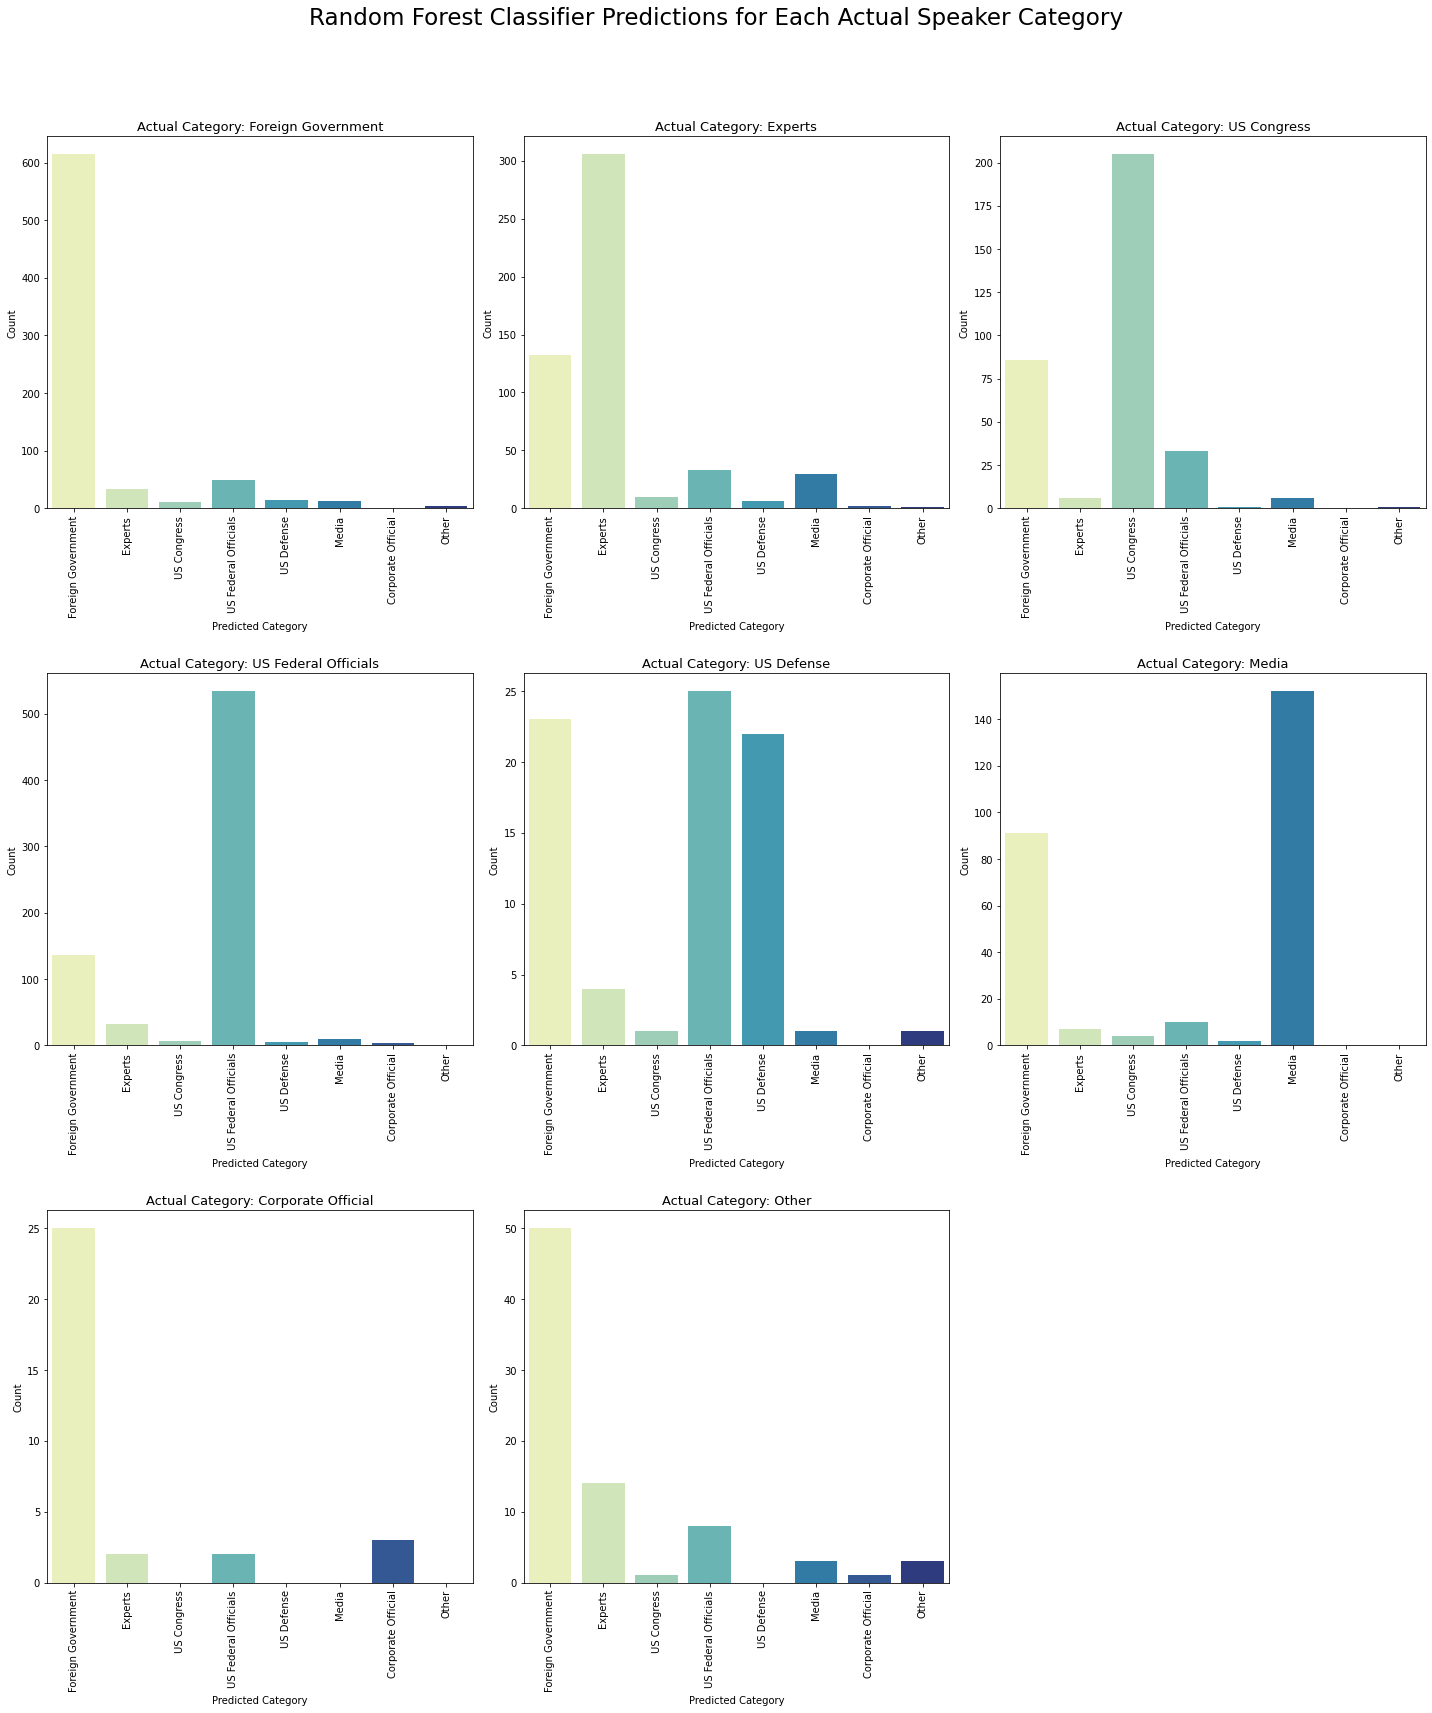

In [41]:
# plotting the results of the code above: a complete error analysis of where the model predicts
# correctly and incorrectly
fig = plt.figure(figsize=(20,25))
fig.suptitle("Random Forest Classifier Predictions for Each Actual Speaker Category",fontsize=23);
i = 0
for category in source_groups:
    code = 331 + i
    i += 1
    ax = fig.add_subplot(code)
    sns.barplot(x='index', y=category, data=count_df, palette="YlGnBu")
    plt.xlabel('');
    ax.set_title("\nActual Category: " + category,fontsize=13);
    ax.set_ylabel("Count");
    ax.set_xlabel("Predicted Category");
    ax.set_xticklabels(ordering.keys(),rotation=90);
plt.tight_layout(rect=[0, 0.03, 1, 0.95]);